In [1]:
# Handle warnings
from warnings import simplefilter
from statsmodels.tools.sm_exceptions import ConvergenceWarning
simplefilter('ignore', ConvergenceWarning)
from warnings import filterwarnings
filterwarnings("ignore")
# Data Libraries
import numpy as np
np.seterr(divide="ignore", invalid="ignore")
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)
# Statistic Libraries
import statsmodels.api as sm
# Machine Learning Libraries
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC, LinearSVC
from sklearn.utils.fixes import loguniform
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# Plot Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# cosmetic options
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
rc = {"figure.figsize": (6.4, 4.8),
      "figure.dpi": 300,
      "axes.titlesize": "large",
      "axes.titleweight": "bold",
      "axes.titlepad": 12,
      "axes.titlelocation": "left"}
sns.set_theme(context="notebook", style="darkgrid", color_codes=True, rc=rc)

In [2]:
def import_dataset(filename):
    """
    Import the dataset from the path.

    Parameters
    ----------
        filename : str
            filename with path

    Returns
    -------
        data : DataFrame

    Examples
    --------
        bank_mkt = import_dataset("../data/BankMarketing.csv")
    """
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    bank_mkt["month"] = bank_mkt["month"].replace(month_map)
    # `day_of_week` will be encoded to the corresponding number, e.g. "wed" -> 3
    dow_map = {"mon":1,
               "tue":2,
               "wed":3,
               "thu":4,
               "fri":5}
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].replace(dow_map)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "Int64",
                                      "day_of_week": "Int64",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop 12 duplicated rows
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder ordinal categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    return bank_mkt

In [3]:
def split_dataset(data, preprocessor=None, random_state=62):
    """
    Split dataset into train, test and validation sets using preprocessor.
    Because the random state of validation set is not specified, the validation set will be different each time when the function is called.

    Parameters
    ----------
        data : DataFrame

        preprocessor : Pipeline
        
        random_state : int

    Returns
    -------
        datasets : tuple

    Examples
    --------
        from sklearn.preprocessing import OrdinalEncoder
        data = import_dataset("../data/BankMarketing.csv").interpolate(method="pad").loc[:, ["job", "education", "y"]]
        # To unpack all train, test, and validation sets 
        X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack train and test sets.
        X_train, y_train, X_test, y_test, *other_sets = split_dataset(data, OrdinalEncoder())
        # To unpack test and validation set
        *other_sets, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack only train set.
        X_train, y_train, *other_sets = split_dataset(data, OneHotEncoder())
    """
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for train_index, test_index in train_test_split.split(data.drop("y", axis=1), data["y"]):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]

    X_train = train_set.drop(["duration", "y"], axis=1)
    y_train = train_set["y"].astype("int").to_numpy()
    X_test = test_set.drop(["duration", "y"], axis=1)
    y_test = test_set["y"].astype("int").to_numpy()

    train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for ttrain_index, validate_index in train_validate_split.split(X_train, y_train):
        ttrain_set = train_set.iloc[ttrain_index]
        validate_set = train_set.iloc[validate_index]
    
    X_ttrain = ttrain_set.drop(["duration", "y"], axis=1)
    y_ttrain = ttrain_set["y"].astype("int").to_numpy()
    X_validate = validate_set.drop(["duration", "y"], axis=1)
    y_validate = validate_set["y"].astype("int").to_numpy()

    if preprocessor != None:
        X_train = preprocessor.fit_transform(X_train, y_train)
        X_test = preprocessor.transform(X_test)
        X_ttrain = preprocessor.fit_transform(X_ttrain, y_ttrain)
        X_validate = preprocessor.transform(X_validate)

    return (X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate)

In [4]:
def benchmark(data, preprocessor=None, clf=None):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline, default = None
        
        clf : estimator, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
            
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test" and not isinstance(clf, CatBoostClassifier):
            clf.fit(X_train, y_train)
        y_pred = clf.predict(X)

        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

In [5]:
def dftransform(X,
                drop=None,
                cut=None,
                gen=None,
                cyclic=None,
                target=None,
                fillna=True,
                to_float=False):
    """
    Encode, transform, and generate categorical data in the dataframe.
    
    Parameters
    ----------
        X : DataFrame
        
        drop : list, default = None
        
        gen : list, default = None
        
        cut : list, default = None
        
        external : list, default = None
        
        cyclic : list, default = None

        fillna : boolean, default = True
        
        to_float : boolean, default = False
    
    Returns
    -------
        X : DataFrame

    Examples
    --------
    bank_mkt = import_dataset("../data/BankMarketing.csv")
    X = dftransform(bank_mkt)
    """
    X = X.copy()
    
    if gen != None:
        if "year" in gen or "days" in gen:
            X.loc[X.index < 27682, "year"] = 2008
            X.loc[(27682<=X.index) & (X.index<39118), "year"] = 2009
            X.loc[39118<=X.index, "year"] = 2010
            X["year"] = X["year"].astype("int")
        if "days" in gen:
            X["date"] = pd.to_datetime(X[["month", "year"]].assign(day=1))
            X["lehman"] = pd.to_datetime("2008-09-15")
            X["days"] = X["date"] -  X["lehman"]
            X["days"] = X["days"].dt.days
            X = X.drop(["lehman", "year", "date"], axis=1)
        if "has_previous" in gen:
            X["has_previous"] = X["previous"] > 0
        if "has_default" in gen:
            X["has_default"] = X["default"].notna()
        if "has_marital" in gen:
            X["has_marital"] = X["marital"].notna()

    if cut != None:
        if "pdays" in cut:
            # Cut pdays into categories
            X["pdays"] = pd.cut(X["pdays"], [0, 3, 5, 10, 15, 30, 1000], labels=[3, 5, 10, 15, 30, 1000], include_lowest=True).astype("Int64")
    
    if cyclic != None:
        if "month" in cyclic:
            X['month_sin'] = np.sin(2 * np.pi * X["month"]/12)
            X['month_cos'] = np.cos(2 * np.pi * X["month"]/12)
            X = X.drop("month", axis=1)
        if "day_of_week" in cyclic:
            X['day_sin'] = np.sin(2 * np.pi * X["day_of_week"]/5)
            X['day_cos'] = np.cos(2 * np.pi * X["day_of_week"]/5)
            X = X.drop("day_of_week", axis=1)
            
    # Transform target encoded feature as str
    if target != None:
        X[target] = X[target].astype("str")

    # Other categorical features will be coded as its order in pandas categorical index
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    
    if fillna:
        # Clients who have been contacted but do not have pdays record should be encoded as 999
        # Clients who have not been contacted should be encoded as -999 
        X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
        X["pdays"] = X["pdays"].fillna(-999)
        # Fill other missing values as -1
        X = X.fillna(-1)
    else:
        X = X.astype("float")
    
    if drop != None:
        # Drop features
        X = X.drop(drop, axis=1)
    
    if to_float:
        X = X.astype("float")
    
    return X

In [6]:
# https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure
def render_benchmark(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#334074', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    Examples
    --------
    logit_best = benchmark(bank_mkt, hot_transformer, lrmodel_gs2)
    fig,ax = render_benchmark(logit_best, header_columns=0, col_width=1.5)
    fig.savefig("logit_best.png")
    """
    data = data.round(decimals=3)
    #data = data.rename({"index": "Metrics"}, axis=1)
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values,
                         bbox=bbox,
                         colLabels=data.columns,
                         rowLabels=data.index,
                         colLoc="left",
                         rowLoc="right",
                         **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        elif k[1] < header_columns:
            cell.set_text_props(weight='bold')
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax.get_figure(), ax

# Bank Marketing Data Analytics

# Exploratory Data Analysis

Exploratory Data Analysis is a process to explore the dataset with no assumptions or hypothesis. The objective is to give us enough insights for the future work.

In [7]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [8]:
bank_mkt["y"].count()

41176

In [9]:
bank_mkt["y"].sum()/bank_mkt["y"].count()

0.11266271614532737

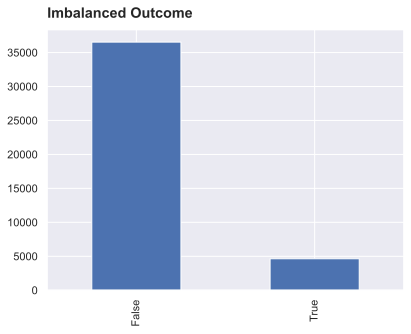

In [10]:
y_count = bank_mkt["y"].value_counts().plot(kind = "bar", title="Imbalanced Outcome")

Using `info()` we can see that most of features concerning the client are categorical/boolean type. And some fields such as `job`, `marital`, `education`, etc. are missing.

In [11]:
bank_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41176 non-null  Int64   
 1   job             40846 non-null  category
 2   marital         41096 non-null  category
 3   education       39446 non-null  category
 4   default         32580 non-null  boolean 
 5   housing         40186 non-null  boolean 
 6   loan            40186 non-null  boolean 
 7   contact         41176 non-null  category
 8   month           41176 non-null  Int64   
 9   day_of_week     41176 non-null  Int64   
 10  duration        41176 non-null  Int64   
 11  campaign        41176 non-null  Int64   
 12  pdays           1515 non-null   Int64   
 13  previous        41176 non-null  Int64   
 14  poutcome        5625 non-null   boolean 
 15  emp.var.rate    41176 non-null  float64 
 16  cons.price.idx  41176 non-null  float64 
 17  cons.conf.id

## Time-ordered Data

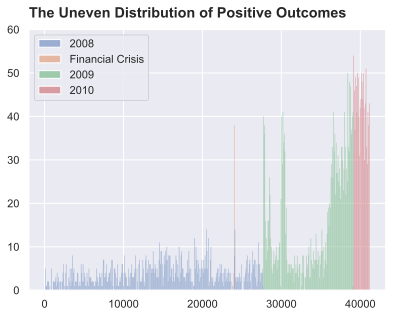

In [12]:
bank_year = bank_mkt.copy()
bank_year["year"]=2008
bank_year.loc[27682:, "year"] = 2009
bank_year.loc[39118:, "year"] = 2010
p = bank_year[bank_year.y == True].reset_index()
p.loc[(p.month == 10) & (p.year==2008), "year"] = "Financial Crisis"
ax = sns.histplot(data=p, x="index", stat="count", hue="year", bins=500, palette="deep", legend=True)
ax.get_legend().set_title("")
ax.set_ylim(0,60)
ax.set(title="The Uneven Distribution of Positive Outcomes", xlabel="", ylabel="");

Oct 2008 is a special case possibly due to the financial crisis.

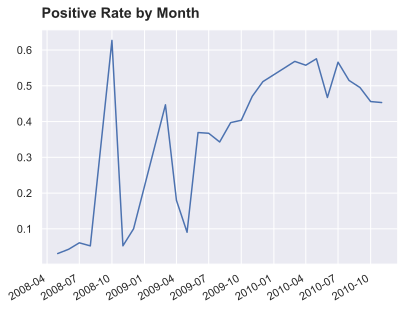

In [13]:
bank_year["date"] = pd.to_datetime(bank_year[["month", "year"]].assign(day=1))
bank_year["y"] = bank_year["y"].astype("int")
bank_year[["date", "y"]].groupby("date").mean().plot.line(xlabel="", ylabel="", title="Positive Rate by Month", legend=False);

### Missing values

By checking the number of missing values, we can see nearly all client do not have `pdays` and `poutcome`. 20% of the clients do not have information of `default`.

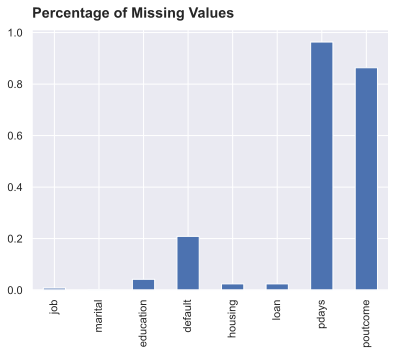

In [14]:
na = bank_mkt.isna().sum()
na_nonzero = na[na != 0]
na_perc = na_nonzero/bank_mkt.y.count()
na_bar = na_perc.plot.bar(title="Percentage of Missing Values")

### Client Data

Let's start with client data. Most of the clients's age are between 32 to 47 while there are some outlier cases beyond 70. This may imply that we should choose standardization for scaling since it's more tolerant for outliers. From the graph below we can see that the age distribution in the true outcome group has lower median age but is more skewed toward an slightly older population.

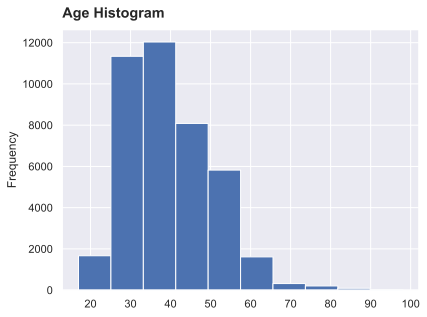

In [15]:
bank_mkt["age"].plot.hist(title="Age Histogram");

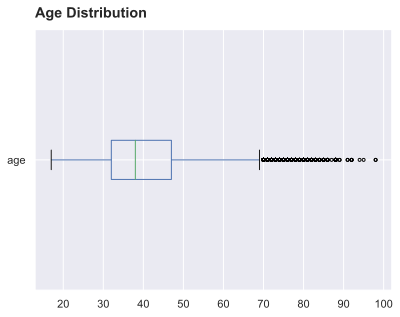

In [16]:
bank_mkt["age"].plot.box(vert=False, sym=".", title="Age Distribution");

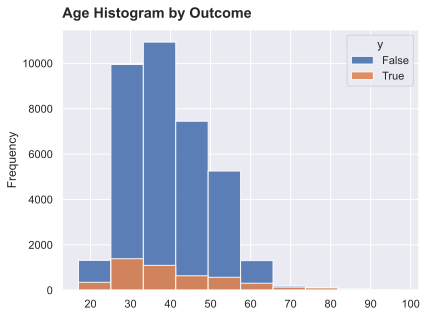

In [17]:
age_y = bank_mkt[["age", "y"]].pivot(columns="y", values="age")
age_y.plot.hist(alpha=0.9, legend=True, title="Age Histogram by Outcome");

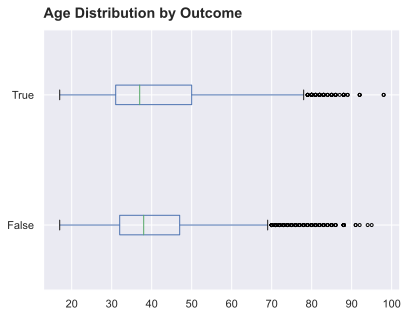

In [18]:
age_y.plot.box(vert=False, sym=".", title="Age Distribution by Outcome");

In [19]:
def cat_outcome(df, feature):
    df = df.copy()
    if pd.api.types.is_categorical_dtype(df[feature]) and df[feature].isna().sum() > 0:
        df[feature] = df[feature].cat.add_categories("unknown")
        df[feature] = df[feature].fillna("unknown")
    title = feature.title().replace("_", " ").replace("Of", "of")
    f, axs = plt.subplots(1, 2, figsize=(8.6, 4.8), sharey=True, gridspec_kw=dict(wspace=0.04, width_ratios=[5, 2]))
    ax0 = df["y"].groupby(df[feature], dropna=False).value_counts(normalize=True).unstack().plot.barh(xlabel="", legend=False, stacked=True, ax=axs[0], title=f"Outcome Percentage and Total by {title}")
    ax1 = df["y"].groupby(df[feature], dropna=False).value_counts().unstack().plot.barh(xlabel="", legend=False, stacked=True, ax=axs[1])

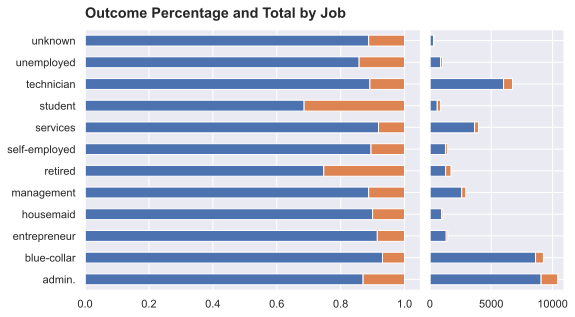

In [20]:
job_outcome = cat_outcome(bank_mkt, "job")

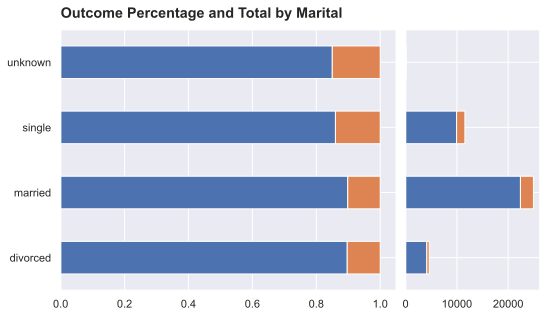

In [21]:
marital_outcome = cat_outcome(bank_mkt, "marital")

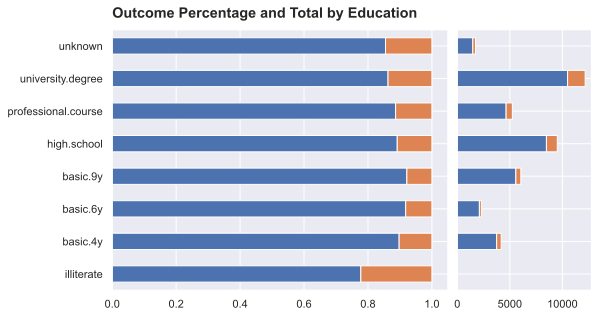

In [22]:
education_outcome = cat_outcome(bank_mkt, "education")

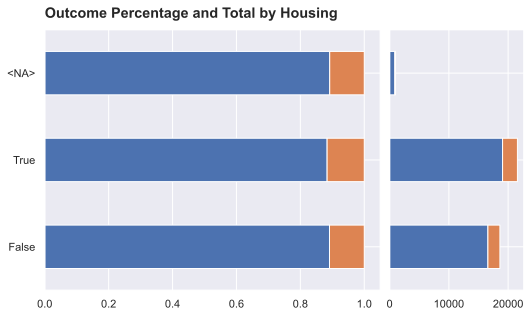

In [23]:
housing_outcome = cat_outcome(bank_mkt, "housing")

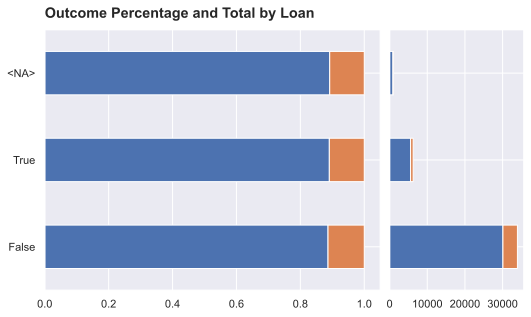

In [24]:
loan_outcome = cat_outcome(bank_mkt, "loan")

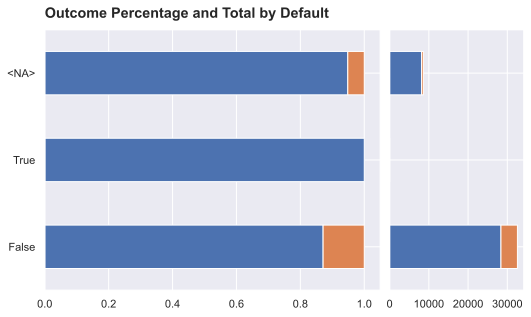

In [25]:
default_outcome = cat_outcome(bank_mkt, "default")

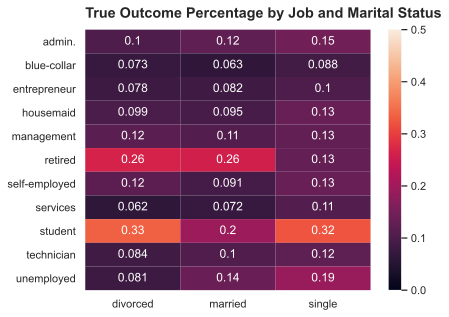

In [26]:
job_marital_total = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).count().y.unstack()
job_marital_true = bank_mkt[["job", "marital", "y"]].groupby(["job", "marital"]).sum().y.unstack()
job_marital_rate = job_marital_true / job_marital_total
job_marital_rate = job_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
sns.heatmap(data=job_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Marital Status");

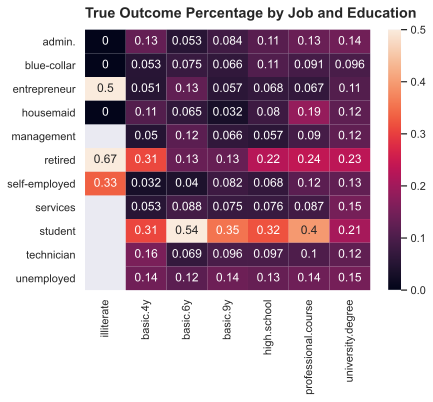

In [27]:
job_education_total = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).count().y.unstack()
job_education_true = bank_mkt[["job", "education", "y"]].groupby(["job", "education"]).sum().y.unstack()
job_education_rate = job_education_true / job_education_total
job_education_rate = job_education_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
sns.heatmap(data=job_education_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Job and Education");

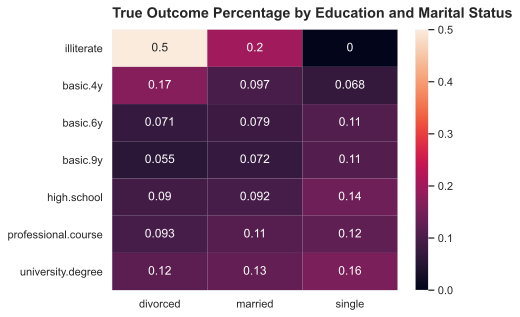

In [28]:
education_marital_total = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).count().y.unstack()
education_marital_true = bank_mkt[["education", "marital", "y"]].groupby(["education", "marital"]).sum().y.unstack()
education_marital_rate = education_marital_true / education_marital_total
education_marital_rate = education_marital_rate.rename_axis(None, axis=0).rename_axis(None, axis=1)
sns.heatmap(data=education_marital_rate, vmin=0, vmax=0.5, annot=True).set_title("True Outcome Percentage by Education and Marital Status");

### Current Campaign

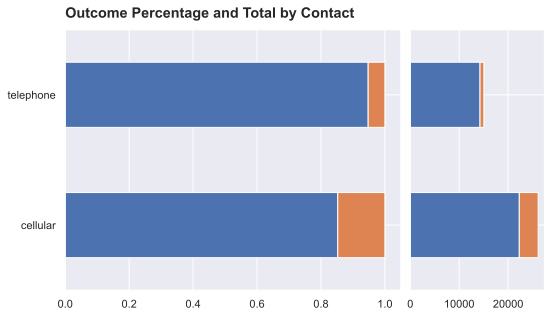

In [29]:
cat_outcome(bank_mkt, "contact")

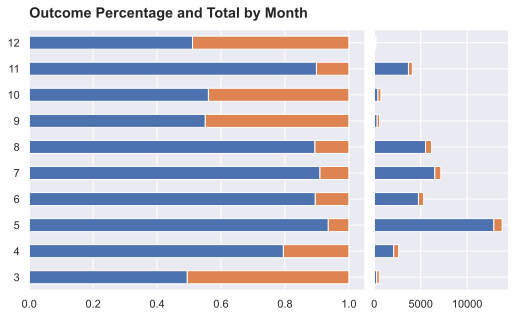

In [30]:
cat_outcome(bank_mkt, "month")

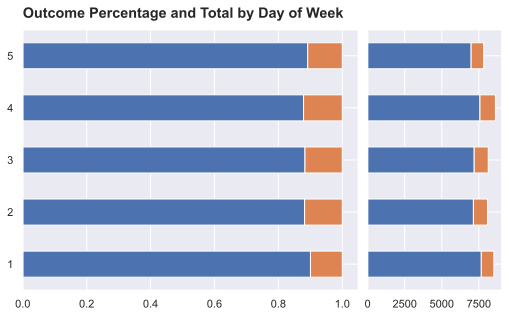

In [31]:
cat_outcome(bank_mkt, "day_of_week")

### Previous Campaign

We can plot the dirstribution of `pdays` and `previous`. As we can see, most of the client with `pdays` has been contacted 3 to 6 days before and peaked at 3 and 6 days.

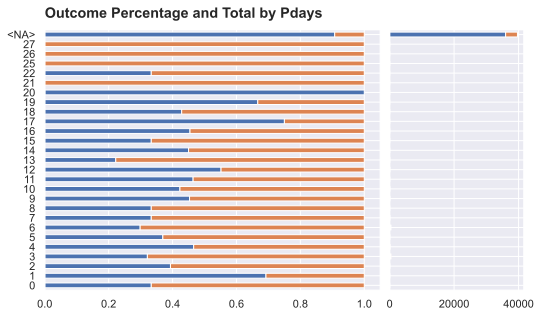

In [32]:
cat_outcome(bank_mkt, "pdays")

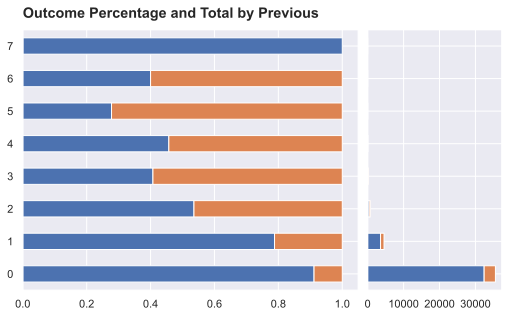

In [33]:
cat_outcome(bank_mkt, "previous")

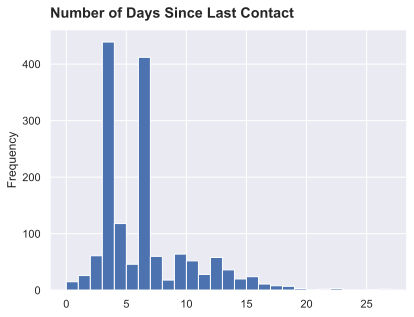

In [34]:
bank_mkt["pdays"].plot.hist(bins=27, title="Number of Days Since Last Contact");

Most of the client has never been contacted before.

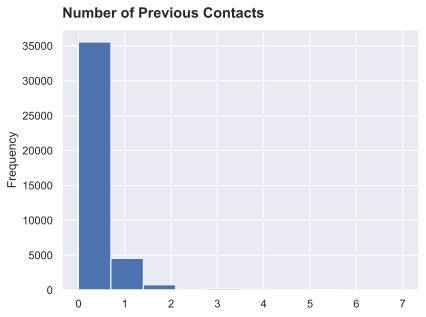

In [35]:
bank_mkt["previous"].plot.hist(title="Number of Previous Contacts");

If `pdays` is missing value, that means that the client was not previously contacted and therefore should not have `poutcome`. But `poutcome` column has less missing values than `pdays`. 

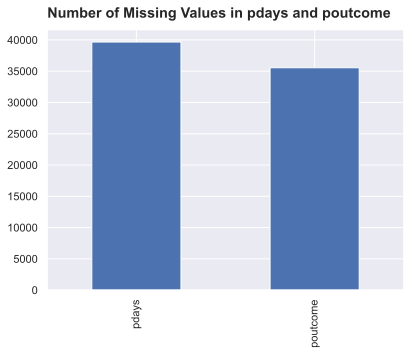

In [36]:
previous_na = bank_mkt[["pdays", "poutcome"]].isna().sum()
previous_na.plot.bar(title="Number of Missing Values in pdays and poutcome");

### Correlation Heatmap

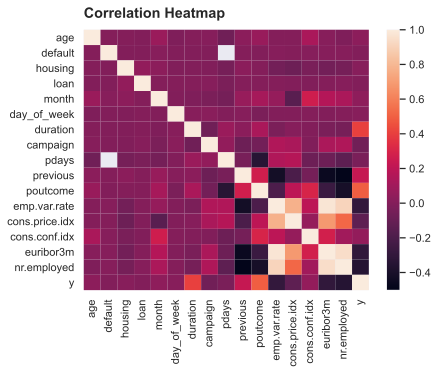

In [37]:
corr_heatmap = sns.heatmap(data=bank_mkt.corr(method="pearson")).set_title("Correlation Heatmap")

# Data Preparation and Feature Engineering

## Import Dataset

We wrote a function `import_dataset()` to make sure duplicated rows, missing values, categorical and boolean data are properly processed by pandas.

In [38]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

## Partition

We need to split the dataset into trainning set and test set, then we train models on the trainning set and only use test set for final validation purposes. However, simply sampling the dataset may lead to unrepresenatative partition given that our dataset is imbalanced and clients have different features. To solve this problem, `scikit-learn` provides a useful function to select representative data as test data. We created a function `split_dataset()` to handle this process and train set splitting.

In [39]:
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt)

## Preprocessors

We wrote a function `dftransform()` to allow us to do transformations in pandas then we use can pipelines to wrap it with other transformers. `benchmark()` is a function that utilises all the functions we wrote and output a clear performance result of our models.

In [40]:
cat_encoder = FunctionTransformer(dftransform, kw_args={"to_float":True})
cat_clf = CatBoostClassifier(eval_metric="AUC", class_weights=[1, 8])
cat_baseline = benchmark(bank_mkt, cat_encoder, cat_clf)
cat_baseline

Train  Validate      Test
TNR   0.859813  0.852378  0.862069
TPR   0.683058  0.628032  0.640086
bACC  0.771435  0.740205  0.751078
ROC   0.864958  0.786536  0.806817
REC   0.683058  0.628032  0.640086
PRE   0.382209  0.350640  0.370787
AP    0.547400  0.453438  0.477314

In [41]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

hot_transformer = make_pipeline(FunctionTransformer(dftransform), hot_scaler)
logit_clf = LogisticRegression(penalty="none", class_weight="balanced", max_iter=10000)
logit_baseline = benchmark(bank_mkt, hot_transformer, logit_clf)
logit_baseline

Train  Validate      Test
TNR   0.800282  0.803455  0.803229
TPR   0.665881  0.665768  0.658405
bACC  0.733082  0.734612  0.730817
ROC   0.788123  0.774415  0.782561
REC   0.665881  0.665768  0.658405
PRE   0.297427  0.300670  0.298194
AP    0.446192  0.427905  0.441638

## Impute Missing Values

### Use Most Frequent Values

In [42]:
freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

freq_encoder = make_pipeline(cat_encoder, freq_imputer)
cat_freq = benchmark(bank_mkt, freq_encoder, cat_clf)
pd.concat([cat_baseline, cat_freq], keys=["Catboost Baseline", "Catboost Frequent"], axis=1)

Catboost Baseline                     Catboost Frequent            \
                 Train  Validate      Test             Train  Validate   
TNR           0.859813  0.852378  0.862069          0.854467  0.851522   
TPR           0.683058  0.628032  0.640086          0.650387  0.637466   
bACC          0.771435  0.740205  0.751078          0.752427  0.744494   
ROC           0.864958  0.786536  0.806817          0.823747  0.803218   
REC           0.683058  0.628032  0.640086          0.650387  0.637466   
PRE           0.382209  0.350640  0.370787          0.362017  0.352722   
AP            0.547400  0.453438  0.477314          0.506633  0.465069   

                
          Test  
TNR   0.858922  
TPR   0.636853  
bACC  0.747888  
ROC   0.802930  
REC   0.636853  
PRE   0.364365  
AP    0.472699

In [43]:
# Select "job", "marital", "education"
cat_features = [0,1,2]

# Select "age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
num_features = [5,10,11,12,14,15,16,17,18]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

freq_transformer = make_pipeline(FunctionTransformer(dftransform), freq_imputer, hot_scaler)
logit_freq = benchmark(bank_mkt, freq_transformer, logit_clf)
pd.concat([logit_baseline, logit_freq], keys=["Logistic Baseline", "Logistic Frequent"], axis=1)

Logistic Baseline                     Logistic Frequent            \
                 Train  Validate      Test             Train  Validate   
TNR           0.800282  0.803455  0.803229          0.799256  0.804311   
TPR           0.665881  0.665768  0.658405          0.659481  0.672507   
bACC          0.733082  0.734612  0.730817          0.729369  0.738409   
ROC           0.788123  0.774415  0.782561          0.784800  0.783796   
REC           0.665881  0.665768  0.658405          0.659481  0.672507   
PRE           0.297427  0.300670  0.298194          0.294348  0.303713   
AP            0.446192  0.427905  0.441638          0.442548  0.427905   

                
          Test  
TNR   0.802135  
TPR   0.665948  
bACC  0.734041  
ROC   0.782449  
REC   0.665948  
PRE   0.299419  
AP    0.442444

### Estimate Missing Values 

In [44]:
ite_features = ["age", "job", "marital", "education", "default", "housing", "loan", "contact", "campaign", "month", "day_of_week", "pdays", "previous"]

ite_imputer = ColumnTransformer([
    ("ite_imputer",
     make_pipeline(
         IterativeImputer(max_iter=100, missing_values=-1, initial_strategy="most_frequent", random_state=42),
         FunctionTransformer(np.round)
     ),
     ite_features),
], remainder="passthrough")

ite_encoder = make_pipeline(cat_encoder, ite_imputer)
cat_ite = benchmark(bank_mkt, ite_encoder, cat_clf)
pd.concat([cat_baseline, cat_ite], keys=["Catboost Baseline", "Catboost Iterative"], axis=1)

Catboost Baseline                     Catboost Iterative            \
                 Train  Validate      Test              Train  Validate   
TNR           0.859813  0.852378  0.862069           0.863277  0.859562   
TPR           0.683058  0.628032  0.640086           0.652071  0.648248   
bACC          0.771435  0.740205  0.751078           0.757674  0.753905   
ROC           0.864958  0.786536  0.806817           0.835749  0.816717   
REC           0.683058  0.628032  0.640086           0.652071  0.648248   
PRE           0.382209  0.350640  0.370787           0.377167  0.369432   
AP            0.547400  0.453438  0.477314           0.517698  0.478020   

                
          Test  
TNR   0.865490  
TPR   0.630388  
bACC  0.747939  
ROC   0.807463  
REC   0.630388  
PRE   0.373087  
AP    0.477912

In [45]:
# Select "job", "marital", "education", "default", "housing", "loan", "poutcome"
cat_features = [1,2,3,4,5,13]

# Select "age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
num_features = [0,8,9,10,12,14,15,16,17,18]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

ite_transformer = make_pipeline(FunctionTransformer(dftransform), ite_imputer, hot_scaler)
logit_ite = benchmark(bank_mkt, ite_transformer, logit_clf)
pd.concat([logit_baseline, logit_ite], keys=["Logistic Baseline", "Logistic Iterative"], axis=1)

Logistic Baseline                     Logistic Iterative            \
                 Train  Validate      Test              Train  Validate   
TNR           0.800282  0.803455  0.803229           0.791772  0.791481   
TPR           0.665881  0.665768  0.658405           0.665207  0.671159   
bACC          0.733082  0.734612  0.730817           0.728489  0.731320   
ROC           0.788123  0.774415  0.782561           0.782548  0.785994   
REC           0.665881  0.665768  0.658405           0.665207  0.671159   
PRE           0.297427  0.300670  0.298194           0.288574  0.290041   
AP            0.446192  0.427905  0.441638           0.444882  0.402337   

                
          Test  
TNR   0.794745  
TPR   0.663793  
bACC  0.729269  
ROC   0.781719  
REC   0.663793  
PRE   0.291115  
AP    0.441374

## Cut `pdays` and Generate `has_previous`

In [46]:
cut_encoder = FunctionTransformer(dftransform, kw_args={"cut": ["pdays"],
                                                        "gen": ["has_previous"],
                                                        "to_float":True})
cat_cut = benchmark(bank_mkt, cut_encoder, cat_clf)
pd.concat([cat_baseline, cat_cut], keys=["Catboost Baseline", "Catboost Cut"], axis=1)

Catboost Baseline                     Catboost Cut                    
                 Train  Validate      Test        Train  Validate      Test
TNR           0.859813  0.852378  0.862069     0.858829  0.848443  0.859332
TPR           0.683058  0.628032  0.640086     0.673964  0.667116  0.641164
bACC          0.771435  0.740205  0.751078     0.766397  0.757780  0.750248
ROC           0.864958  0.786536  0.806817     0.857381  0.805741  0.809997
REC           0.683058  0.628032  0.640086     0.673964  0.667116  0.641164
PRE           0.382209  0.350640  0.370787     0.377405  0.358436  0.366605
AP            0.547400  0.453438  0.477314     0.537094  0.463141  0.477533

In [47]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome",
                "pdays"]

num_features = ["age", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

cut_encoder = FunctionTransformer(dftransform, kw_args={"cut": ["pdays"],
                                                        "gen": ["has_previous"]})
cut_transformer = make_pipeline(cut_encoder, hot_scaler)
logit_cut = benchmark(bank_mkt, cut_transformer, logit_clf)
pd.concat([logit_baseline, logit_cut], keys=["Logistic Baseline", "Logistic Cut"], axis=1)

Logistic Baseline                     Logistic Cut                    
                 Train  Validate      Test        Train  Validate      Test
TNR           0.800282  0.803455  0.803229     0.803532  0.817482  0.803093
TPR           0.665881  0.665768  0.658405     0.658808  0.671159  0.658405
bACC          0.733082  0.734612  0.730817     0.731170  0.744321  0.730749
ROC           0.788123  0.774415  0.782561     0.783845  0.791557  0.782570
REC           0.665881  0.665768  0.658405     0.658808  0.671159  0.658405
PRE           0.297427  0.300670  0.298194     0.298626  0.318211  0.298049
AP            0.446192  0.427905  0.441638     0.442517  0.442093  0.439822

## Generate `days` Since Financial Crisis

In [48]:
days_encoder = FunctionTransformer(dftransform, kw_args={"gen": ["days"],
                                                         "to_float":True})
cat_days = benchmark(bank_mkt, days_encoder, cat_clf)
pd.concat([cat_baseline, cat_days], keys=["Catboost Baseline", "Catboost Days"], axis=1)

Catboost Baseline                     Catboost Days                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.859813  0.852378  0.862069      0.854852  0.854772  0.859195
TPR           0.683058  0.628032  0.640086      0.658808  0.629380  0.636853
bACC          0.771435  0.740205  0.751078      0.756830  0.742076  0.748024
ROC           0.864958  0.786536  0.806817      0.828266  0.798205  0.807187
REC           0.683058  0.628032  0.640086      0.658808  0.629380  0.636853
PRE           0.382209  0.350640  0.370787      0.365607  0.354863  0.364815
AP            0.547400  0.453438  0.477314      0.509119  0.467423  0.476878

In [49]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features = ["age",
                "campaign",
                "previous",
                "emp.var.rate",
                "cons.price.idx",
                "cons.conf.idx",
                "euribor3m",
                "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

days_encoder = FunctionTransformer(dftransform, kw_args={"gen": ["days"]})
days_transformer = make_pipeline(days_encoder, hot_scaler)
logit_days = benchmark(bank_mkt, days_transformer, logit_clf)
pd.concat([logit_baseline, logit_days], keys=["Logistic Baseline", "Logistic Days"], axis=1)

Logistic Baseline                     Logistic Days                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.800282  0.803455  0.803229      0.807681  0.799521  0.807745
TPR           0.665881  0.665768  0.658405      0.675312  0.657682  0.669181
bACC          0.733082  0.734612  0.730817      0.741496  0.728601  0.738463
ROC           0.788123  0.774415  0.782561      0.793214  0.783757  0.788045
REC           0.665881  0.665768  0.658405      0.675312  0.657682  0.669181
PRE           0.297427  0.300670  0.298194      0.308367  0.293976  0.306515
AP            0.446192  0.427905  0.441638      0.445741  0.427133  0.446091

## Drop Features

In [50]:
drop_features = ["age",
                 "job",
                 "marital",
                 "education",
                 "housing",
                 "loan",
                 "default"]

drop_encoder = FunctionTransformer(dftransform, kw_args={"drop": drop_features,
                                                         "to_float":True})

In [51]:
cat_drop = benchmark(bank_mkt, drop_encoder, cat_clf)
pd.concat([cat_baseline, cat_drop], keys=["CatBoost Baseline", "CatBoost Drop"], axis=1)

CatBoost Baseline                     CatBoost Drop                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.859813  0.852378  0.862069      0.850404  0.847246  0.853859
TPR           0.683058  0.628032  0.640086      0.653755  0.644205  0.639009
bACC          0.771435  0.740205  0.751078      0.752080  0.745725  0.746434
ROC           0.864958  0.786536  0.806817      0.816931  0.813666  0.811535
REC           0.683058  0.628032  0.640086      0.653755  0.644205  0.639009
PRE           0.382209  0.350640  0.370787      0.356867  0.348651  0.357014
AP            0.547400  0.453438  0.477314      0.495369  0.467877  0.483341

In [52]:
cat_features = ["poutcome"]

num_features =  ["campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

drop_encoder = FunctionTransformer(dftransform, kw_args={"drop": drop_features})

drop_transformer = make_pipeline(drop_encoder, hot_scaler)

logit_drop = benchmark(bank_mkt, drop_transformer, logit_clf)
pd.concat([logit_baseline, logit_drop], keys=["Logistic Baseline", "Logistic Drop"], axis=1)

Logistic Baseline                     Logistic Drop                    
                 Train  Validate      Test         Train  Validate      Test
TNR           0.800282  0.803455  0.803229      0.785357  0.782073  0.791598
TPR           0.665881  0.665768  0.658405      0.668575  0.684636  0.656250
bACC          0.733082  0.734612  0.730817      0.726966  0.733355  0.723924
ROC           0.788123  0.774415  0.782561      0.777234  0.788721  0.782417
REC           0.665881  0.665768  0.658405      0.668575  0.684636  0.656250
PRE           0.297427  0.300670  0.298194      0.283409  0.285073  0.285647
AP            0.446192  0.427905  0.441638      0.431128  0.441288  0.434224

# Evaluation

In [53]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [54]:
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt,
                                                              FunctionTransformer(dftransform))

In [55]:
names = ["Constant Prediction",
         "Random Prediction",
         "K-Nearest Neighbors",
         "Linear SVM",
         "Decision Tree",
         "Logistic Regression"]

clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        KNeighborsClassifier(n_neighbors=10),
        SGDClassifier(loss="hinge", class_weight="balanced"),
        DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
        LogisticRegression(class_weight="balanced")]

n = len(names)

In [56]:
y_pred = {}
for name, clf in zip(names, clfs):
    y_pred[name] = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=-1)

In [57]:
y_score = {}

y_threshold = {}

for name, clf in zip(names, clfs):
    if hasattr(clf, "decision_function"):
        response_method = "decision_function"
    else:
        response_method = "predict_proba"
        
    y_score[name] = cross_val_predict(clf,
                                      X_train,
                                      y_train,
                                      cv=5,
                                      n_jobs=-1,
                                      method=response_method)
    
    if name == "Logistic Regression":
        # For logistic regression, the hyperplane refered in the decision function is b_0+b_1x_1+...b_kx_k.
        # When hyperplane is 0, the probablity is 0.5,
        # therefore the threshold of decision function for logistic regression is 0.
        # https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun
        y_threshold[name] = 0
    elif name == "Linear SVM":
        y_threshold[name] = 0
    else:
        y_score[name] = y_score[name][:, 1]
        y_threshold[name] = 0.5

## Confusion Matrix

The function `cross_val_predict` returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. It is not appropriate for measuring generalisation error but suited for comparing different models.

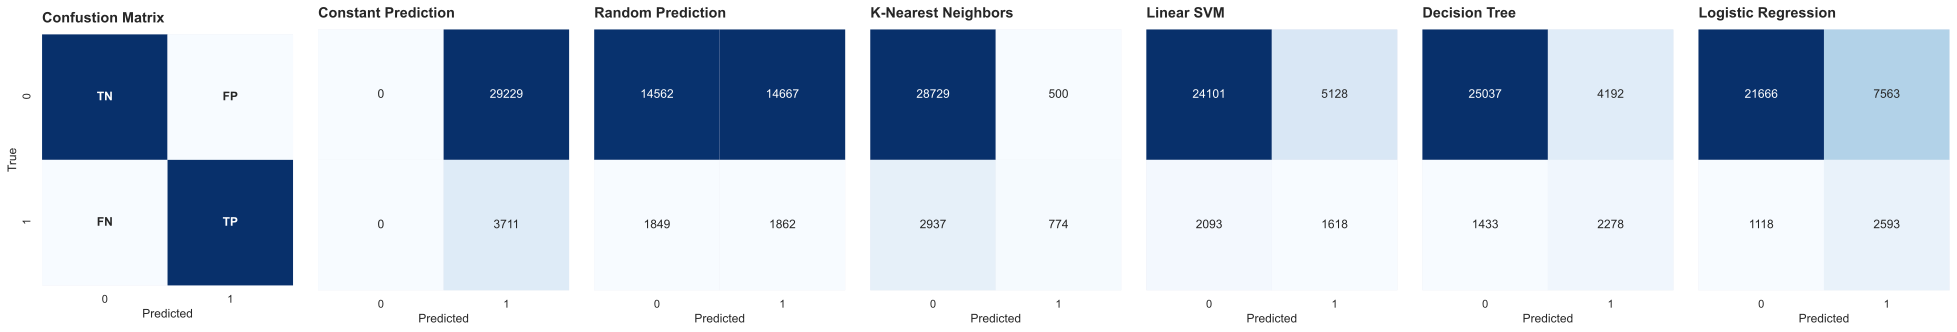

In [58]:
f, axs = plt.subplots(1, n+1, figsize=(4.8*(n+1)+0.1*n, 4.8), sharey=True, gridspec_kw=dict(wspace=0.1))

conf_mat = np.array([[100, 30], [30, 100]])
conf_label = np.array([["TN", "FP"], ["FN", "TP"]])
conf_ax = sns.heatmap(conf_mat,
                      ax=axs[0],
                      annot=conf_label,
                      annot_kws={"fontweight": "bold"},
                      fmt="",
                      square=True,
                      cmap=plt.cm.Blues, 
                      cbar=False)
conf_ax.set_xlabel("Predicted")
conf_ax.set_ylabel("True")
conf_ax.set_title("Confustion Matrix")

for i, name in zip(range(1, n+1), names):
    conf_mat = confusion_matrix(y_train, y_pred[name])
    conf_ax = sns.heatmap(conf_mat, 
                          ax=axs[i], 
                          annot=True, 
                          fmt="", 
                          cmap=plt.cm.Blues, 
                          cbar=False)
    conf_ax.set(xlabel="Predicted", title=name)

## Performance Matrics

From the Confusion Matrix, we can deride some key performance metrics. The false positive rate (FPR) measures the error rate of the negative outcomes:

$$
FPR = \frac{FP}{N} = \frac{FP}{FP+TN}
$$

The true negative rate (TNR) measures the accuracy rate for the negative outcomes:

$$
TNR = \frac{TP}{N} = \frac{TN}{TN+FP} = 1 - FPR
$$

The true positive rate (TPR) measures the accuracy rate for the positive outcomes:

$$
TPR = \frac{TP}{P} = \frac{TP}{TP+FN}
$$

Balanced accuracy is the average of true positive rate and true negative rate:

$$
bACC = \frac{TPR+TNR}{2}
$$

True positive rate is also known as recall (REC):

$$
REC = TPR = \frac{TP}{TP+FN}
$$

Precision (PRE) measures the accuracy of the predicted positive outcomes:

$$
PRE = \frac{TP}{TP+FP}
$$

To balance the up- and down-sides of optimizing PRE and REC, the harmonic mean of precision and recall is used:

$$
F_1 = 2 \cdot \frac{PRE \times REC}{PRE + REC}
$$

In [59]:
matric_names = ["FPR", "TNR", "TPR", "bACC", "REC", "PRE", "F1"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [1-recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name])]
    matric_df[name] = matrics

matric_df

Constant Prediction  Random Prediction  K-Nearest Neighbors  Linear SVM  \
FPR              1.000000           0.501796             0.017106    0.175442   
TNR              0.000000           0.498204             0.982894    0.824558   
TPR              1.000000           0.501752             0.208569    0.436001   
bACC             0.500000           0.499978             0.595731    0.630279   
REC              1.000000           0.501752             0.208569    0.436001   
PRE              0.112659           0.112650             0.607535    0.239846   
F1               0.202505           0.183992             0.310532    0.309458   

      Decision Tree  Logistic Regression  
FPR        0.143419             0.258750  
TNR        0.856581             0.741250  
TPR        0.613851             0.698733  
bACC       0.735216             0.719992  
REC        0.613851             0.698733  
PRE        0.352087             0.255317  
F1         0.447500             0.373981

## Receiver Operating Characteristic

A receiver operating characteristic (ROC) is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting TPR against FPR at various threshold settings.

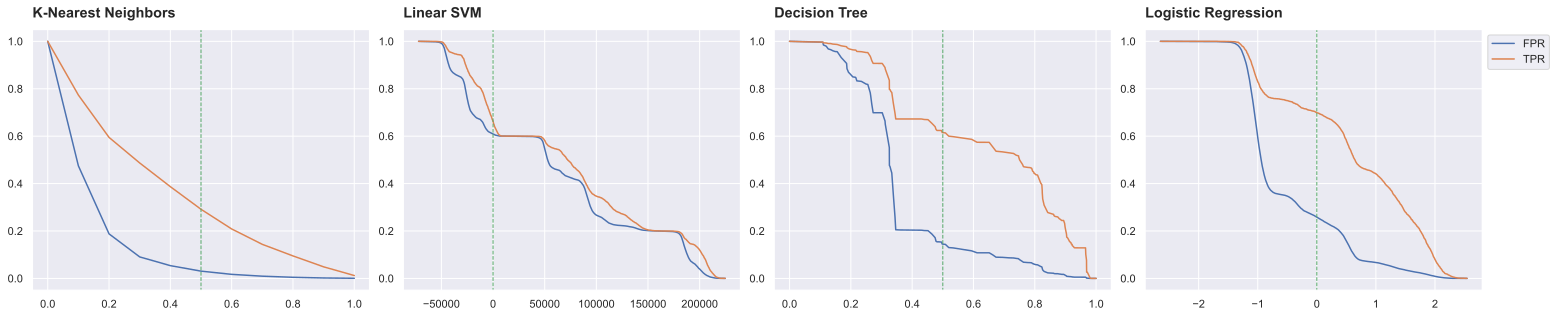

In [60]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    fprs, tprs, thresholds = roc_curve(y_train, y_score[name])
    roc_df = pd.DataFrame({"FPR": fprs[1:], "TPR": tprs[1:]}, index=thresholds[1:])
    ax = roc_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    
    threshold = y_threshold[name]
    ax.plot((threshold, threshold), (-2,2),  linestyle="--", linewidth=1)
    
#     tnrs = 1 - fprs
#     ax.plot(thresholds[1:], tnrs[1:], color="k", label="TNR")
    
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

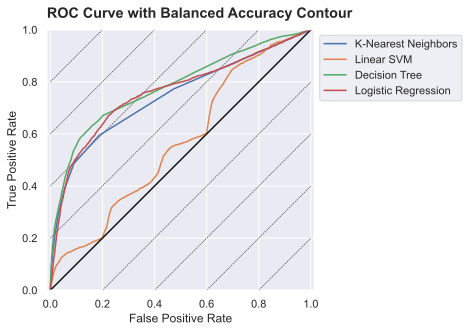

In [61]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def bacc(x, y):
    return (1-x+y)/2

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
Z = bacc(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    fpr, tpr, thresholds = roc_curve(y_train, y_score[name])
    ax.plot(fpr, tpr, label=name)
    
ax.plot([0, 1], [0, 1], color="k")
ax.axis("equal")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel="False Positive Rate",
       ylabel="True Positive Rate",
       title="ROC Curve with Balanced Accuracy Contour");

## Precision-Recall Curve

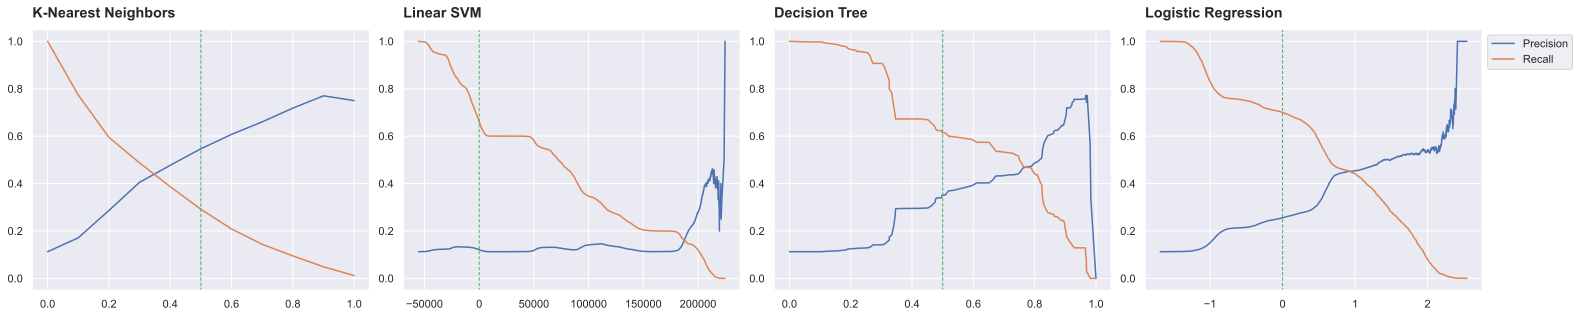

In [62]:
f, axs = plt.subplots(1, n-2, figsize=(6.4*(n-2)+0.1*(n-2), 4.8), gridspec_kw=dict(wspace=0.1))

for i, name in zip(range((n-2)), names[2:]):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precision_recall_df = pd.DataFrame({"Precision": precisions[:-1], "Recall": recalls[:-1]}, index=thresholds)
    ax = precision_recall_df.plot.line(ax=axs[i], ylim=(-0.05,1.05), legend=False, title=name)
    
    threshold = y_threshold[name]
    ax.plot((threshold, threshold), (-2,2),  linestyle="--", linewidth=1)
    
    if i == n-3:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

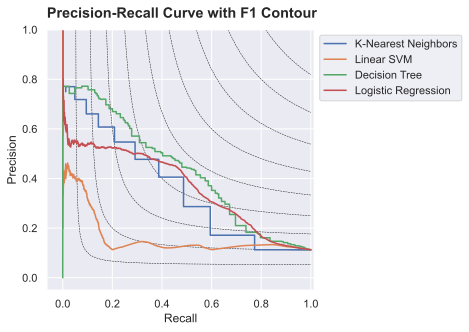

In [63]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def f1(x, y):
    return 2*x*y/(x+y)

x = np.linspace(0.01,1)
y = np.linspace(0.01,1)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, precisions, drawstyle="steps-post", label=name)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis("equal")
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve with F1 Contour")

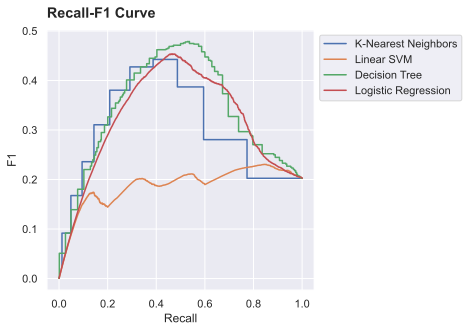

In [64]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, 2*recalls*precisions/(recalls+precisions), drawstyle="steps-post", label=name)
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="F1", title="Recall-F1 Curve")

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

$$
AP = \sum_{n} (REC_n - REC_{n-1})PRE_n
$$

In [65]:
matric_names = ["FPR", "TNR", "TPR", "bACC", "ROC", "REC", "PRE", "F1", "AP"]
matric_df = pd.DataFrame(index=matric_names, columns=names)

for name, clf in zip(names, clfs):
    matrics = [1-recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name], pos_label=0),
               recall_score(y_train, y_pred[name]),
               balanced_accuracy_score(y_train, y_pred[name]),
               roc_auc_score(y_train, y_score[name]),
               recall_score(y_train, y_pred[name]),
               precision_score(y_train, y_pred[name]),
               f1_score(y_train, y_pred[name]),
               average_precision_score(y_train, y_score[name])]
    matric_df[name] = matrics

matric_df

Constant Prediction  Random Prediction  K-Nearest Neighbors  Linear SVM  \
FPR              1.000000           0.501796             0.017106    0.175442   
TNR              0.000000           0.498204             0.982894    0.824558   
TPR              1.000000           0.501752             0.208569    0.436001   
bACC             0.500000           0.499978             0.595731    0.630279   
ROC              0.500000           0.500000             0.744049    0.566165   
REC              1.000000           0.501752             0.208569    0.436001   
PRE              0.112659           0.112650             0.607535    0.239846   
F1               0.202505           0.183992             0.310532    0.309458   
AP               0.112659           0.112659             0.360609    0.161801   

      Decision Tree  Logistic Regression  
FPR        0.143419             0.258750  
TNR        0.856581             0.741250  
TPR        0.613851             0.698733  
bACC       0.735216             0.719992  
ROC        0.780383             0.759634  
REC        0.613851             0.698733  
PRE        0.352087             0.255317  
F1         0.447500             0.373981  
AP         0.430274             0.364674

# Logistic Regression

In [66]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [67]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

hot_transformer = make_pipeline(FunctionTransformer(dftransform), hot_scaler)

X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, hot_transformer)

In [68]:
lrmodel = LogisticRegression(class_weight='balanced',max_iter=10000) 
lrmodel.fit(X_train, y_train)
y_train_pred = lrmodel.predict(X_train)
#### model measures for training data
cmtr = confusion_matrix(y_train, y_train_pred)
acctr = accuracy_score(y_train, y_train_pred)
aps_train = average_precision_score(y_train, y_train_pred)

#### fit test set data
lrmodel.fit(X_test, y_test)
y_test_pred = lrmodel.predict(X_test)
#### model measures for testing data
cmte = confusion_matrix(y_test, y_test_pred)
accte = accuracy_score(y_test, y_test_pred)
aps_test = average_precision_score(y_test, y_test_pred)

print('Accuracy Score:',acctr, '    APS:',aps_train)
print('Accuracy Score:',accte, '    APS:',aps_test)

Accuracy Score: 0.7842440801457194     APS: 0.23513806070216542
Accuracy Score: 0.7967459932005828     APS: 0.23951134518112


In [69]:
benchmark(bank_mkt, hot_transformer, lrmodel)

Train  Validate      Test
TNR   0.800539  0.797810  0.802682
TPR   0.665207  0.667116  0.658405
bACC  0.732873  0.732463  0.730544
ROC   0.785689  0.785720  0.782580
REC   0.665207  0.667116  0.658405
PRE   0.297485  0.295170  0.297613
AP    0.440082  0.441531  0.441895

## Grid Search 


In [70]:
#### Try the 1st GridSearch param_grid combination:
lrmodel = LogisticRegression(class_weight='balanced', max_iter=10000)

#### Grid Search
param_grid = {'penalty': ['l2'],
              'C':[0.001,.009,0.01,0.05,0.09,5,10,25,50,100]}
GS_lrmodel_1 = GridSearchCV(lrmodel, param_grid, scoring='average_precision', n_jobs=-1)
GS_lrmodel_1.fit(X_train, y_train)
lrmodel_gs1 = lrmodel.set_params(**GS_lrmodel_1.best_params_)

#### use calibrated model on train set
lrmodel_gs1.fit(X_train, y_train)
y_train_pred = lrmodel_gs1.predict(X_train)
y_train_score = lrmodel_gs1.decision_function(X_train)
cmtr_gs1 = confusion_matrix(y_train, y_train_pred)
acctr_gs1 = accuracy_score(y_train, y_train_pred)
aps_train_gs1 = average_precision_score(y_train, y_train_score)

#### test the model
lrmodel_gs1.fit(X_test, y_test)
y_test_pred = lrmodel_gs1.predict(X_test)
y_test_score = lrmodel_gs1.decision_function(X_test)
cmte_gs1 = confusion_matrix(y_test, y_test_pred)
accte_gs1 = accuracy_score(y_test, y_test_pred)
aps_test_gs1 = average_precision_score(y_test, y_test_score)

print('Confusion Matrix:\n',cmtr_gs1,'\nAccuracy Score:\n',acctr_gs1, '\nAPS:\n',aps_train_gs1)
print('Confusion Matrix:\n',cmte_gs1,'\nAccuracy Score:\n',accte_gs1, '\nAPS:\n',aps_test_gs1)
print('best parameters:',GS_lrmodel_1.best_params_)

Confusion Matrix:
 [[23371  5858]
 [ 1239  2472]] 
Accuracy Score:
 0.7845476624165149 
APS:
 0.4411373521838609
Confusion Matrix:
 [[5961 1347]
 [ 326  602]] 
Accuracy Score:
 0.7968674113647402 
APS:
 0.44868919696893533
best parameters: {'C': 5, 'penalty': 'l2'}


In [71]:
benchmark(bank_mkt, hot_transformer, lrmodel_gs1)

Train  Validate      Test
TNR   0.803704  0.789429  0.803093
TPR   0.661839  0.679245  0.658405
bACC  0.732771  0.734337  0.730749
ROC   0.783799  0.789585  0.782555
REC   0.661839  0.679245  0.658405
PRE   0.299771  0.290490  0.298049
AP    0.443973  0.426292  0.441772

In [72]:
#### Try the 2nd GridSearch param_grid combination:
lrmodel_gs = LogisticRegression(class_weight='balanced',max_iter=10000)

#### Grid Search
param_grid = {"C":[0.001,.009,0.01,0.05,0.09,5,10,25,50,100], 
              "penalty":["l1","elasticnet"],
              "solver": ["saga"]}
GS_lrmodel_2 = GridSearchCV(lrmodel_gs, param_grid, scoring='average_precision', n_jobs=-1)
GS_lrmodel_2.fit(X_train, y_train)
lrmodel_gs2 = lrmodel_gs.set_params(**GS_lrmodel_2.best_params_)

#### use calibrated model on train set
lrmodel_gs2.fit(X_train, y_train)
y_train_pred = lrmodel_gs2.predict(X_train)
y_train_score = lrmodel_gs1.decision_function(X_train)
cmtr_gs2 = confusion_matrix(y_train, y_train_pred)
acctr_gs2 = accuracy_score(y_train, y_train_pred)
aps_train_gs2 = average_precision_score(y_train, y_train_pred)
#### test the model
lrmodel_gs2.fit(X_test, y_test)
y_test_pred = lrmodel_gs2.predict(X_test)
y_test_score = lrmodel_gs1.decision_function(X_test)
cmte_gs2 = confusion_matrix(y_test, y_test_pred)
accte_gs2 = accuracy_score(y_test, y_test_pred)
aps_test_gs2 = average_precision_score(y_test, y_test_score)

print('Confusion Matrix:\n',cmtr_gs2,'\nAccuracy Score:\n',acctr_gs1, '\nAPS:\n',aps_train_gs1)
print('Confusion Matrix:\n',cmte_gs2,'\nAccuracy Score:\n',accte_gs2, '\nAPS:\n',aps_test_gs2)
print('best parameters:',GS_lrmodel_2.best_params_)

Confusion Matrix:
 [[23207  6022]
 [ 1235  2476]] 
Accuracy Score:
 0.7845476624165149 
APS:
 0.4411373521838609
Confusion Matrix:
 [[5870 1438]
 [ 317  611]] 
Accuracy Score:
 0.7869111219038368 
APS:
 0.441772139472023
best parameters: {'C': 0.05, 'penalty': 'l1', 'solver': 'saga'}


In [73]:
benchmark(bank_mkt, hot_transformer, lrmodel_gs2)

Train  Validate      Test
TNR   0.795492  0.792850  0.798166
TPR   0.663860  0.692722  0.660560
bACC  0.729676  0.742786  0.729363
ROC   0.782667  0.789498  0.782780
REC   0.663860  0.692722  0.660560
PRE   0.291870  0.297971  0.293582
AP    0.443300  0.439171  0.441013

## Statistical Properties

In [74]:
freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

# Select "job", "marital", "education"
cat_features = [0,1,2]

# Select "age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
num_features = [5,10,11,12,14,15,16,17,18]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

freq_transformer = make_pipeline(FunctionTransformer(dftransform, kw_args={"drop": ["duration", "y"]}), freq_imputer, hot_scaler)
X = freq_transformer.fit_transform(bank_mkt)
X = np.array(X, dtype=float)
y = bank_mkt["y"].astype("int").to_numpy()

In [75]:
logit_model = sm.Logit(y, X)
result = logit_model.fit(maxiter=1000)
print(result.summary())

         Current function value: 0.281094
         Iterations: 1000
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41176
Model:                          Logit   Df Residuals:                    41142
Method:                           MLE   Df Model:                           33
Date:                Thu, 12 Nov 2020   Pseudo R-squ.:                  0.2015
Time:                        15:58:57   Log-Likelihood:                -11574.
converged:                      False   LL-Null:                       -14496.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2317      0.066     -3.507      0.000      -0.361      -0.102
x2            -0.1243      0.106     -1.173      0.241      -0.

# SVM

In [76]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [77]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

hot_transformer = make_pipeline(FunctionTransformer(dftransform), hot_scaler)

X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, hot_transformer)

## Linear SVM

In [78]:
linear_svm = LinearSVC(dual=False, class_weight="balanced", random_state=42)

In [79]:
param_distributions = {"loss": ["squared_hinge", "hinge"],
                       "C": loguniform(1e0, 1e3)}

random_search = RandomizedSearchCV(linear_svm,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=100)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'C': 1.1361548657024574, 'loss': 'squared_hinge'}, with mean test score: 0.43354326475418103


In [80]:
param_grid = [
    {"C": [5,2,1]}
    ]
grid_search = GridSearchCV(linear_svm,
                           param_grid,
                           scoring="average_precision",
                           return_train_score=True,
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'C': 1}, with mean test score: 0.43356240611668306


In [81]:
linear_svm = LinearSVC(loss="squared_hinge", C=1, dual=False, class_weight="balanced", random_state=42)
benchmark(bank_mkt, hot_transformer, linear_svm)

Train  Validate      Test
TNR   0.795108  0.791310  0.795703
TPR   0.664534  0.691375  0.659483
bACC  0.729821  0.741342  0.727593
ROC   0.785562  0.786010  0.781580
REC   0.664534  0.691375  0.659483
PRE   0.291691  0.296018  0.290736
AP    0.435728  0.432823  0.437258

## Non-Linear SVM

The Nystroem method, as implemented in Nystroem is a general method for low-rank approximations of kernels. It achieves this by essentially subsampling the data on which the kernel is evaluated.

In [82]:
rbf_sgd_clf = Pipeline([
    ("rbf", RBFSampler(random_state=42)),
    ("svm", SGDClassifier(class_weight="balanced"))
])

In [83]:
param_distributions = {
    "rbf__gamma": loguniform(1e-6, 1e-3),
    "svm__alpha": loguniform(1e-10, 1e-6)}

random_search = RandomizedSearchCV(rbf_sgd_clf,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=10)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.0007087711398938291, 'svm__alpha': 1.2269339879156183e-07}, with mean test score: 0.4350168498949894


In [84]:
param_grid = {
    "rbf__gamma": [0.0008, 0.0001, 0.001],
    "svm__alpha": [1e-7, 1e-6, 1e-5]}

grid_search = GridSearchCV(rbf_sgd_clf,
                           param_grid,
                           scoring="average_precision",
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.0008, 'svm__alpha': 1e-06}, with mean test score: 0.4403394302575112


In [85]:
rbf_sgd_tuned = rbf_sgd_clf.set_params(rbf__gamma=0.0009, svm__alpha=1e-6)
benchmark(bank_mkt, hot_transformer, rbf_sgd_tuned)

Train  Validate      Test
TNR   0.792798  0.797639  0.644499
TPR   0.678680  0.681941  0.752155
bACC  0.735739  0.739790  0.698327
ROC   0.791381  0.789337  0.786777
REC   0.678680  0.681941  0.752155
PRE   0.293732  0.299586  0.211772
AP    0.436139  0.444426  0.437136

In [86]:
rbf_clf = Pipeline([
    ("rbf", RBFSampler(random_state=42)),
    ("svm", LinearSVC(loss="squared_hinge", dual=False, class_weight="balanced", max_iter=1000))
])

In [87]:
param_distributions = {
    "rbf__gamma": loguniform(1e-6, 1e-3),
    "svm__C": loguniform(1e-1, 1e1)}

random_search = RandomizedSearchCV(rbf_clf,
                                   param_distributions,
                                   scoring="average_precision",
                                   cv=5,
                                   n_jobs=-1,
                                   n_iter=10)

grid_fit = random_search.fit(X_train, y_train)
grid_results = random_search.cv_results_
grid_best_params = random_search.best_params_
grid_best_score = random_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.00026560333125098774, 'svm__C': 6.5900965177317055}, with mean test score: 0.4381080007088255


In [88]:
param_grid = {
    "rbf__gamma": [0.0001, 0.001, 0.01],
    "svm__C": [1, 10, 20]}

grid_search = GridSearchCV(rbf_clf,
                           param_grid,
                           scoring="average_precision",
                           cv=5,
                           n_jobs=-1)

grid_fit = grid_search.fit(X_train, y_train)
grid_results = grid_search.cv_results_
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

best parameters found: {'rbf__gamma': 0.001, 'svm__C': 10}, with mean test score: 0.43986477417883973


In [89]:
rbf_tuned = rbf_clf.set_params(rbf__gamma=0.0009, svm__C=1)
benchmark(bank_mkt, hot_transformer, rbf_tuned)

Train  Validate      Test
TNR   0.788906  0.787889  0.794745
TPR   0.677669  0.676550  0.668103
bACC  0.733288  0.732220  0.731424
ROC   0.787619  0.782527  0.784626
REC   0.677669  0.676550  0.668103
PRE   0.289580  0.288175  0.292453
AP    0.437404  0.453640  0.440392

# Neural Network

In [90]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [91]:
cat_features = ["job",
                "marital",
                "education",
                "default",
                "housing",
                "loan",
                "poutcome"]

num_features =  ["age",
                 "campaign",
                 "pdays",
                 "previous",
                 "emp.var.rate",
                 "cons.price.idx",
                 "cons.conf.idx",
                 "euribor3m",
                 "nr.employed"]

hot_scaler = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(drop="first"), cat_features),
    ("scaler", StandardScaler(), num_features)
], remainder="passthrough")

hot_transformer = make_pipeline(FunctionTransformer(dftransform), hot_scaler)

X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, hot_transformer)

# Grid Search

In [92]:
mlp=MLPClassifier(random_state=42,max_iter=1000)

param_grid ={
    'solver':['lbfgs', 'sgd', 'adam'],
    'learning_rate':["constant","invscaling","adaptive"],
    'hidden_layer_sizes':[(100,),(200,),(20,5,),(10,5,),(100,50,25,)],
    'alpha':[0.0,0.001,0.01],
    'activation' :["logistic","relu","tanh"] }

grid_search = GridSearchCV(estimator=mlp,
                          param_grid=param_grid,
                          scoring = "average_precision",
                          return_train_score=True,
                          cv = 5,
                          n_jobs=-1) 
       
#grid_fit = grid_search.fit(X_train, y_train)
#grid_results = grid_search.cv_results_
#grid_best_params = grid_search.best_params_
#grid_best_score = grid_search.best_score_
#print(f"best parameters found: {grid_best_params}, with mean test score: {grid_best_score}")

In [93]:
mlp_trained=MLPClassifier(solver ="lbfgs",
                          random_state=42,
                          max_iter=1000,
                          activation = 'relu',
                          alpha = 0.01,
                          hidden_layer_sizes = (100,),
                          learning_rate = 'constant')

nn_best = benchmark(bank_mkt, hot_transformer, mlp_trained)

In [94]:
nn_best

Train  Validate      Test
TNR   0.984219  0.959117  0.969896
TPR   0.470192  0.295148  0.310345
bACC  0.727206  0.627133  0.640120
ROC   0.900857  0.730865  0.746097
REC   0.470192  0.295148  0.310345
PRE   0.790935  0.478166  0.566929
AP    0.688217  0.354089  0.396211

# Decision Tree and Its Ensembles

In [95]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [96]:
tree_transformer = FunctionTransformer(dftransform)
X_train, y_train, X_test, y_test, *other_sets = split_dataset(bank_mkt, tree_transformer)

In [97]:
RF = RandomForestClassifier(random_state=42,class_weight="balanced",criterion ="gini",max_features="auto", 
                           min_samples_split= 2)

param_grid = {
    'max_depth':[6,8,10],
    'n_estimators':[1000,1500,1750,2000]
}
CV_RFmodel = GridSearchCV(estimator=RF,param_grid=param_grid,scoring="average_precision",n_jobs=-1,cv=2)
CV_RFmodel.fit(X_train,y_train)
grid_results = CV_RFmodel.cv_results_
grid_best_params = CV_RFmodel.best_params_
grid_best_score = CV_RFmodel.best_score_
grid_best_estimator = CV_RFmodel.best_estimator_
print(f"best mean test score: {grid_best_score}, for {grid_best_estimator}")

best mean test score: 0.454011896674566, for RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=1000,
                       random_state=42)


In [98]:
RF_validation = RandomForestClassifier(random_state=42,class_weight="balanced",max_depth=6,n_estimators=1500,
                                       max_leaf_nodes=1000)
benchmark(bank_mkt, tree_transformer, RF_validation)

Train  Validate      Test
TNR   0.869606  0.864352  0.870963
TPR   0.626137  0.633423  0.618534
bACC  0.747871  0.748887  0.744749
ROC   0.812612  0.798343  0.801848
REC   0.626137  0.633423  0.618534
PRE   0.378769  0.372130  0.378378
AP    0.503004  0.453244  0.474725

In [99]:
columns = bank_mkt.drop(["duration", "y"], axis=1).columns.tolist()
rnd_clf = RandomForestClassifier(n_estimators=1750,max_depth=6, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
for name, importance in zip(columns, rnd_clf.feature_importances_):
    print(name, "=", importance)

age = 0.022920894128878735
job = 0.006566986254514234
marital = 0.003385873429150797
education = 0.006149466295854508
default = 0.0033650201091385474
housing = 0.0020795708322661408
loan = 0.0020097234460168794
contact = 0.015413456359833133
month = 0.032509206447392906
day_of_week = 0.010037493056285719
campaign = 0.007439017409714185
pdays = 0.04169110188490772
previous = 0.024848097678077736
poutcome = 0.1464224351363468
emp.var.rate = 0.08557673013420532
cons.price.idx = 0.05613380396274621
cons.conf.idx = 0.08063914582862237
euribor3m = 0.2190466803668966
nr.employed = 0.23376529723915143


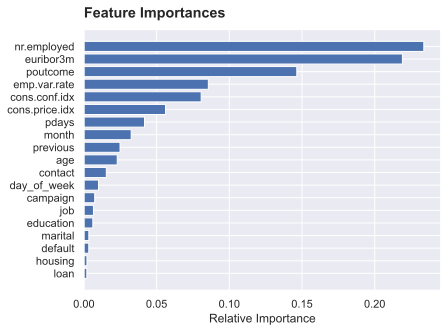

In [100]:
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("Feature importance.png")
plt.size=(15,10)
plt.show()

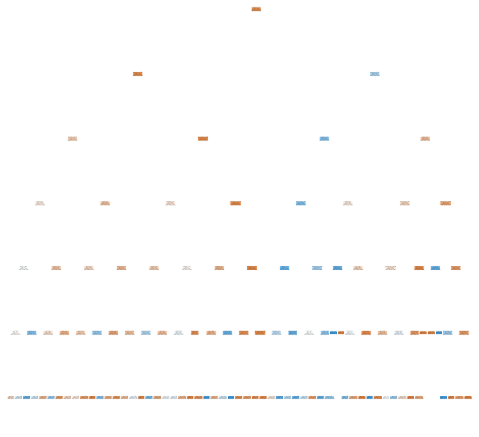

In [101]:
fn= columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,2), dpi=300)
plot_tree(rnd_clf.estimators_[0],
          feature_names = fn,
          filled = True,
          proportion=True);
#fig.savefig('rf_individualtree.png')

In [102]:
AB= AdaBoostClassifier(n_estimators=100,random_state=42,learning_rate=1.0)

param_grid = {
    'learning_rate':[0.8],
    'n_estimators':[800],
    'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=4)]
}
CV_RFmodel = GridSearchCV(estimator=AB,param_grid=param_grid,scoring="average_precision",n_jobs=-1,cv=2)
CV_RFmodel.fit(X_train,y_train)
grid_results = CV_RFmodel.cv_results_
grid_best_params = CV_RFmodel.best_params_
grid_best_score = CV_RFmodel.best_score_
grid_best_estimator = CV_RFmodel.best_estimator_
print(f"best mean test score: {grid_best_score}, for {grid_best_estimator}")

best mean test score: 0.448988423603947, for AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.8, n_estimators=800, random_state=42)


In [103]:
AB_validation = AdaBoostClassifier(n_estimators=800,learning_rate=0.8,random_state=42,
                                       base_estimator = DecisionTreeClassifier(max_depth=2,min_samples_split=2))

benchmark(bank_mkt, tree_transformer, AB_validation)

Train  Validate      Test
TNR   0.985374  0.975539  0.976601
TPR   0.373863  0.288410  0.300647
bACC  0.679619  0.631974  0.638624
ROC   0.875065  0.773080  0.785003
REC   0.373863  0.288410  0.300647
PRE   0.764463  0.599440  0.620000
AP    0.619684  0.427388  0.438897

In [104]:
for name, importance in zip(columns, AB_validation.feature_importances_):
    print(name, "=", importance)

age = 0.1947034653644713
job = 0.07827703019506096
marital = 0.029143558436130673
education = 0.05488075683168286
default = 0.02091542902209133
housing = 0.01981330979998421
loan = 0.026874365827603972
contact = 0.024437235385322865
month = 0.02922753290623781
day_of_week = 0.04257663483447152
campaign = 0.12000726385478286
pdays = 0.025715599307905755
previous = 0.026675620963622183
poutcome = 0.01188106977253431
emp.var.rate = 0.00969928145539651
cons.price.idx = 0.025113188884970744
cons.conf.idx = 0.040096984134051175
euribor3m = 0.2072398090740467
nr.employed = 0.012721863949632433


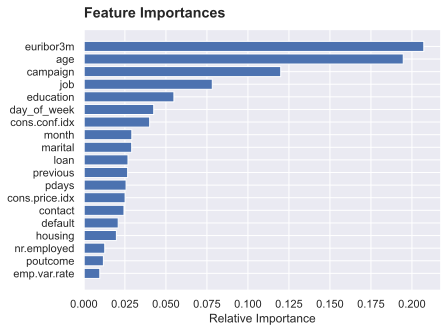

In [105]:
importances = AB_validation.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
#plt.savefig("Feature importance.png")
plt.size=(15,10)
#plt.savefig("Feature importance_ada.png")
plt.show()

# Ensemble Method

In [106]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [107]:
cat_clf = make_pipeline(FunctionTransformer(dftransform, kw_args={"drop": drop_features,
                                                                  "to_float":True}),
                        CatBoostClassifier(eval_metric="AUC", class_weights=[1, 8], verbose=False))

benchmark(bank_mkt, None, cat_clf)

Train  Validate      Test
TNR   0.868451  0.865207  0.864532
TPR   0.688447  0.586253  0.627155
bACC  0.778449  0.725730  0.745844
ROC   0.856187  0.773511  0.805929
REC   0.688447  0.586253  0.627155
PRE   0.399219  0.355683  0.370229
AP    0.571032  0.442015  0.476444

In [108]:
drop_features = ["age",
                 "job",
                 "marital",
                 "education",
                 "housing",
                 "loan",
                 "default"]

xgb_clf = make_pipeline(FunctionTransformer(dftransform, kw_args= {"drop": drop_features,
                                                                   "gen": ["has_default",
                                                                           "has_marital"],
                                                                   "to_float":True}),
                        XGBClassifier(max_depth=3, gamma=1, min_child_weight=1, scale_pos_weight=8))

benchmark(bank_mkt, None, xgb_clf)

Train  Validate      Test
TNR   0.851431  0.848785  0.856596
TPR   0.666891  0.657682  0.644397
bACC  0.759161  0.753234  0.750496
ROC   0.826015  0.806302  0.812991
REC   0.666891  0.657682  0.644397
PRE   0.363036  0.355685  0.363305
AP    0.515168  0.477416  0.483435

In [109]:
voting_clf = VotingClassifier(
    estimators=[("cat", cat_clf),
                ("xgb", xgb_clf)],
    voting="soft",
    n_jobs=-1)
benchmark(bank_mkt, None, voting_clf)

Train  Validate      Test
TNR   0.863320  0.861957  0.864532
TPR   0.673627  0.625337  0.629310
bACC  0.768473  0.743647  0.746921
ROC   0.843258  0.800359  0.811130
REC   0.673627  0.625337  0.629310
PRE   0.384911  0.365067  0.371029
AP    0.537564  0.492273  0.481529

In [110]:
stacking_clf = StackingClassifier(
    estimators=[("cat", cat_clf),
                ("xgb", xgb_clf)],
    n_jobs=-1)
benchmark(bank_mkt, None, stacking_clf)

Train  Validate      Test
TNR   0.984561  0.982039  0.984537
TPR   0.285281  0.262803  0.268319
bACC  0.634921  0.622421  0.626428
ROC   0.835338  0.790882  0.812842
REC   0.285281  0.262803  0.268319
PRE   0.701159  0.650000  0.687845
AP    0.529741  0.450417  0.483157

# Summary of Modelling

In [111]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [117]:
drop_features = ["age",
                 "job",
                 "marital",
                 "education",
                 "housing",
                 "loan",
                 "default"]

bank_mkt.loc[bank_mkt.index < 27682, "year"] = 2008
bank_mkt.loc[(27682<=bank_mkt.index) & (bank_mkt.index<39118), "year"] = 2009
bank_mkt.loc[39118<=bank_mkt.index, "year"] = 2010
bank_mkt["year"] = bank_mkt["year"].astype("int")
# Drop features improve results in 2008
bank_transform = dftransform(bank_mkt, drop=drop_features, fillna=False, to_float=True)
X = bank_transform.drop(["duration", "y"], axis=1)
y = bank_transform["y"]
xgb_clf = XGBClassifier(max_depth=3, scale_pos_weight=8)
bank_mkt["y_pred"] = cross_val_predict(xgb_clf, X, y)

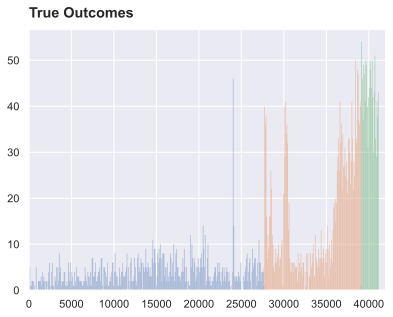

In [118]:
to = bank_mkt[bank_mkt.y == True].reset_index()
ax = sns.histplot(data=to, x="index", stat="count", hue="year", bins=500, palette="deep", legend=False)
ax.set_xlim(0, 42000)
ax.set(xlabel="", ylabel="", title="True Outcomes");

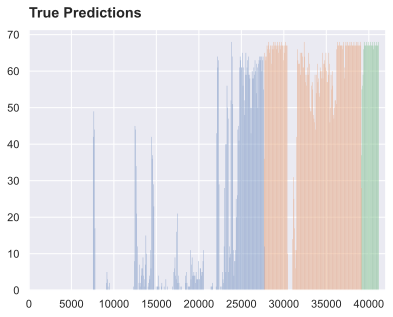

In [119]:
tp = bank_mkt[bank_mkt.y_pred == True].reset_index()
ax = sns.histplot(data=tp, x="index", stat="count", hue="year", bins=500, palette="deep", legend=False)
ax.set_xlim(0, 42000)
ax.set(xlabel="", ylabel="", title="True Predictions");

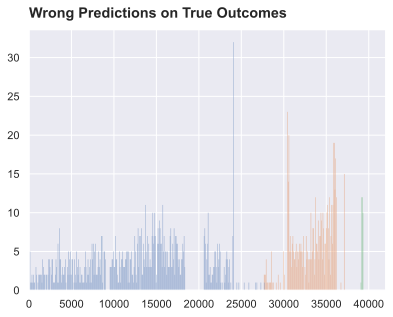

In [120]:
wp = bank_mkt[(bank_mkt.y == True) & (bank_mkt.y_pred == False)].reset_index()
ax = sns.histplot(data=wp, x="index", stat="count", hue="year", bins=500, palette="deep", legend=False)
ax.set_xlim(0, 42000)
ax.set(xlabel="", ylabel="", title="Wrong Predictions on True Outcomes");

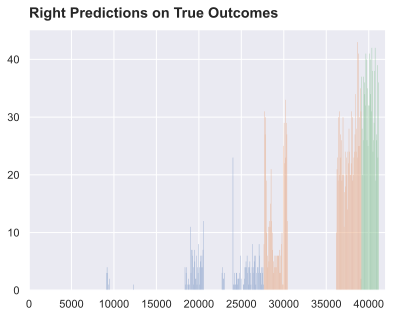

In [121]:
rp = bank_mkt[(bank_mkt.y == True) & (bank_mkt.y_pred == True)].reset_index()
ax = sns.histplot(data=rp, x="index", stat="count", hue="year", bins=500, palette="deep", legend=False)
ax.set_xlim(0, 42000)
ax.set(xlabel="", ylabel="", title="Right Predictions on True Outcomes");